In [ ]:
import os

# Create the images directory if it doesn't exist
os.makedirs('images', exist_ok=True)

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding, multiply
from tensorflow.keras.layers import LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Load the Fashion MNIST dataset
(x_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize the images to [-1, 1]
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

# Define image dimensions and number of classes
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
num_classes = 10


4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
def build_generator():
    noise_shape = (100,)
    label_shape = (1,)

    model = Sequential()

    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    noise = Input(shape=noise_shape)
    label = Input(shape=label_shape, dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, 100)(label))

    model_input = multiply([noise, label_embedding])
    img = model(model_input)

    return Model([noise, label], img)


def build_discriminator():
    img_shape = (img_rows, img_cols, channels)
    label_shape = (1,)

    model = Sequential()

    model.add(Dense(512, input_dim=np.prod(img_shape)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    label = Input(shape=label_shape, dtype='int32')

    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    flat_img = Flatten()(img)

    model_input = multiply([flat_img, label_embedding])

    validity = model(model_input)

    return Model([img, label], validity)


In [ ]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.0002, 0.5),
                      metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise and the target label as input and generates an image
z = Input(shape=(100,))
label = Input(shape=(1,))
img = generator([z, label])

# For the combined model, we will only train the generator
discriminator.trainable = False

# The discriminator takes generated image as input and determines validity
valid = discriminator([img, label])

# The combined model (stacked generator and discriminator)
combined = Model([z, label], valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


In [ ]:
def train(epochs, batch_size=128, sample_interval=50):
    # Load the dataset
    (X_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images and their corresponding labels
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        # Sample noise as generator input
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Generate a batch of new images
        gen_imgs = generator.predict([noise, labels])

        # Train the discriminator (real classified as 1 and fake as 0)
        d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Sample noise and labels as generator input
        noise = np.random.normal(0, 1, (batch_size, 100))
        sampled_labels = np.random.randint(0, 10, (batch_size, 1))

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch([noise, sampled_labels], valid)

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval -> save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch)

def sample_images(epoch):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)

    gen_imgs = generator.predict([noise, sampled_labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].set_title("Class: %d" % sampled_labels[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

# Train the model
train(epochs=20000, batch_size=64, sample_interval=200)


2/2 [==============================] - 1s 6ms/step
0 [D loss: 0.694228, acc.: 28.91%] [G loss: 0.680820]
1/1 [==============================] - 0s 141ms/step


<ipython-input-4-009ffc46c3cf>:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axs[i,j].set_title("Class: %d" % sampled_labels[cnt])


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
8708 [D loss: 0.689819, acc.: 57.03%] [G loss: 0.714356]
2/2 [==============================] - 0s 6ms/step
8709 [D loss: 0.689798, acc.: 53.91%] [G loss: 0.720326]
2/2 [==============================] - 0s 6ms/step
8710 [D loss: 0.689451, acc.: 52.34%] [G loss: 0.715256]
2/2 [==============================] - 0s 5ms/step
8711 [D loss: 0.688295, acc.: 53.12%] [G loss: 0.720734]
2/2 [==============================] - 0s 5ms/step
8712 [D loss: 0.682783, acc.: 56.25%] [G loss: 0.698306]
2/2 [==============================] - 0s 4ms/step
8713 [D loss: 0.690371, acc.: 44.53%] [G loss: 0.713179]
2/2 [==============================] - 0s 6ms/step
8714 [D loss: 0.709864, acc.: 53.12%] [G loss: 0.721066]
2/2 [==============================] - 0s 6ms/step
8715 [D loss: 0.705727, acc.: 47.66%] [G loss: 0.696313]
2/2 [==============================] - 0s 6ms/step
8716 [D loss: 0.689150, acc.: 55.4

Exception ignored in: <function _xla_gc_callback at 0x780860e6c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


2/2 [==============================] - 0s 6ms/step
11201 [D loss: 0.695561, acc.: 50.00%] [G loss: 0.707326]
2/2 [==============================] - 0s 5ms/step
11202 [D loss: 0.690408, acc.: 54.69%] [G loss: 0.713774]
2/2 [==============================] - 0s 5ms/step
11203 [D loss: 0.693520, acc.: 45.31%] [G loss: 0.715648]
2/2 [==============================] - 0s 5ms/step
11204 [D loss: 0.679069, acc.: 60.16%] [G loss: 0.719360]
2/2 [==============================] - 0s 5ms/step
11205 [D loss: 0.698483, acc.: 47.66%] [G loss: 0.710806]
2/2 [==============================] - 0s 5ms/step
11206 [D loss: 0.686297, acc.: 46.88%] [G loss: 0.730799]
2/2 [==============================] - 0s 4ms/step
11207 [D loss: 0.687862, acc.: 50.78%] [G loss: 0.708470]
2/2 [==============================] - 0s 6ms/step
11208 [D loss: 0.690112, acc.: 46.88%] [G loss: 0.717747]
2/2 [==============================] - 0s 6ms/step
11209 [D loss: 0.686280, acc.: 56.25%] [G loss: 0.727987]
2/2 [==============

KeyboardInterrupt: 

1/1 [==============================] - 0s 68ms/step


<ipython-input-5-5be9bca2b03f>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axs[i,j].set_title("Class: %d" % sampled_labels[cnt])


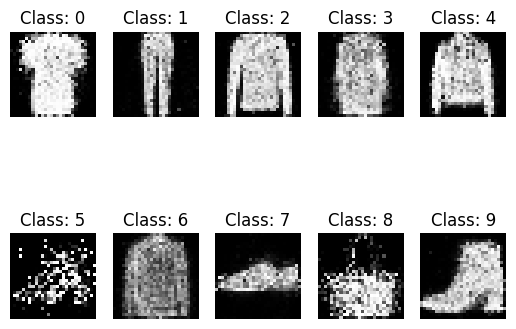

In [ ]:
def visualize_results():
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)

    gen_imgs = generator.predict([noise, sampled_labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].set_title("Class: %d" % sampled_labels[cnt])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()

# Visualize the generated results
visualize_results()
